In [13]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [14]:
# image_no=15590
# img,acceleration,steering=0,1,2
# train[image_no][img]
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from skimage import color

#### Extract data

In [42]:
data_1=np.load("set_1/preprocessed/preprocessed_clock_1.npz",allow_pickle=True)
data_2=np.load("set_1/preprocessed/preprocessed_clock_2.npz",allow_pickle=True)
data_3=np.load("set_1/preprocessed/preprocessed_anticlock_1.npz",allow_pickle=True)
data_4=np.load("set_1/preprocessed/preprocessed_anticlock_2.npz",allow_pickle=True)
train_1=data_1["arr_0"]
train_2=data_2["arr_0"]
train_3=data_3["arr_0"]
train_4=data_4["arr_0"]
print(train_1.shape)
print(train_2.shape)
print(train_3.shape)
print(train_4.shape)
all_data=np.concatenate((train_1,train_2, train_3, train_4), axis = 0)
np.random.shuffle(all_data)
train,test = all_data[0:int(all_data.shape[0]*0.80)],all_data[int(all_data.shape[0]*0.80):all_data.shape[0]]

(6700, 3)
(8100, 3)
(6700, 3)
(8100, 3)


#### Single Sample

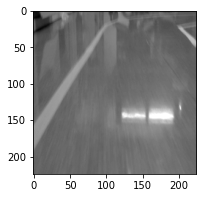

In [43]:
sample=torch.tensor(color.rgb2gray(train[0][0]))
# sample.reshape((1,224,224)).shape ## check shape
plt.figure(figsize=(3,3))
plt.imshow(sample,cmap='gray')
img_shape=sample.shape

#### Compile to pytorch format

In [44]:
train_data=[]
test_data=[]
for val in train:
    gray=torch.tensor(color.rgb2gray(val[0])).unsqueeze(1)
    tup=(gray,torch.tensor(val[2]))
    train_data.append(tup)
    
for val_1 in test:
    gray=torch.tensor(color.rgb2gray(val_1[0])).unsqueeze(1)
    tup=(gray,torch.tensor(val_1[2]))
    test_data.append(tup)
## wrap around data loaders

In [45]:
torch.save(train_data, 'set_1_train.pt')
torch.save(test_data, 'set_1_test.pt')

# Start here

In [15]:
train_data=torch.load("set_1_train.pt")
test_data=torch.load("set_1_test.pt")

In [ ]:
data=train_data
liss=[]
for val in range(len(data)):
    liss.append(train_data[val][1])
plt.hist(liss, bins=10)
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000018321DA2158> (for post_execute):


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\rishabh_ub\appdata\local\programs\python\python36\lib\site-packages\IPython\core\events.py", line 88, in trigger
    func(*args, **kwargs)
  File "c:\users\rishabh_ub\appdata\local\programs\python\python36\lib\site-packages\ipykernel\pylab\backend_inline.py", line 121, in flush_figures
    return show(True)
  File "c:\users\rishabh_ub\appdata\local\programs\python\python36\lib\site-packages\ipykernel\pylab\backend_inline.py", line 43, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "c:\users\rishabh_ub\appdata\local\programs\python\python36\lib\site-packages\IPython\core\display.py", line 313, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "c:\users\rishabh_ub\appdata\local\programs\python\python36\lib\site-packages\IPython\core\formatters.py", line 180, in format
    data = formatter(obj)
  File "<decorator-gen-9>", line 2, in __call__
  File "c:\users\risha

In [ ]:
print(liss)

In [16]:
train_d_loader=torch.utils.data.DataLoader(train_data, batch_size=1000, shuffle=True)
test_d_loader=torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=True)

In [ ]:
test_batch=next(iter(test_d_loader))
t_image,t_label=test_batch
print(t_label)

#### Single batch

In [47]:
batch=next(iter(train_d_loader))
images,labels=batch
images=images.reshape(1000,1,images.shape[3],images.shape[3])
img_shape=images[0][0].shape
sample,sample_l=images[0][0],labels[0]
grid=torchvision.utils.make_grid(images,nrow=10)
# plt.figure(figsize=(15,15))
# plt.imshow(np.transpose(grid,(1,2,0)))
# print("Label")

#### Model

In [48]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(normalized_shape=img_shape)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3,stride=2)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3)
#         self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.drop=nn.Dropout(0.5)

        self.fc1 = nn.Linear(in_features=64*5*5, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=1)

    def forward(self, t):
        self.nnor=t
        t=self.norm(t.float())
        self.nor=t
        
        t = F.elu(self.conv1(t.float()))
        t = F.max_pool2d(t, kernel_size=2)
        
        t = F.elu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2)
        
        
        t = F.elu(self.conv3(t))
        t = F.max_pool2d(t, kernel_size=2)


        t = F.elu(self.conv4(t))
        t = F.max_pool2d(t, kernel_size=2)
#         t = F.elu(self.conv5(t))
#         t = F.max_pool2d(t, kernel_size=2)
        self.t=t
#         print(t.shape)
        
#         t=self.drop(t)
        t=t.reshape(-1,t.shape[1]*t.shape[2]*t.shape[3])
        t=F.elu(self.fc1(t))
        t=F.elu(self.fc2(t))
        t=F.elu(self.fc3(t))
        t=F.elu(self.fc4(t))
        t=self.out(t)
        return t
            
network = Network()

#### Single image prediction

In [49]:
sample=sample.reshape((1,224,224)).unsqueeze(0)
pred= network(sample)
print(pred)
# sample.shape

tensor([[-0.2269]], grad_fn=<AddmmBackward>)


#### Single Image visualization after convolution

c:\users\rishabh_ub\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


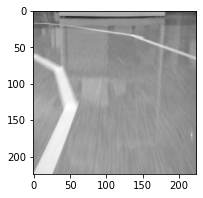

In [50]:
sample_1=torch.tensor(network.nor[0][0])


plt.figure(figsize=(3,3))
plt.imshow(sample_1,cmap='gray')
img_shape=sample.shape

c:\users\rishabh_ub\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


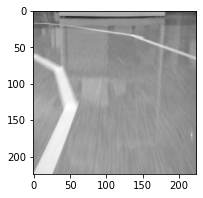

In [51]:
sample_2=torch.tensor(network.nnor[0][0])
plt.figure(figsize=(3,3))
plt.imshow(sample_2,cmap='gray')

#### Single batch prediction

In [136]:
ls=nn.MSELoss()

# t_loader=torch.utils.data.DataLoader(train,batch_size=100)
optimizer=optim.Adam(network.parameters(),lr=0.01)

batch=next(iter(d_loader))
images,labels=batch
images=images.reshape(100,1,images.shape[3],images.shape[3])
# labels=labels.type(torch.LongTensor)

preds = network(images) # Pass Batch
print(preds.type())
print(labels)

loss =ls(preds, labels) # Calculate Loss
loss.item()
optimizer.zero_grad()
loss.backward() # Calculate Gradients
optimizer.step() # Update Weights
loss.item()

NameError: name 'd_loader' is not defined

In [48]:
# t_loader=torch.utils.data.DataLoader(train,batch_size=100)
ls=nn.MSELoss()
optimizer=optim.Adam(network.parameters(),lr=0.01)

t_loss=0
t_correct=0

for batch in d_loader:
    images,labels=batch
    images=images.reshape(images.shape[0],1,224,224)
#     labels=labels.type(torch.LongTensor)
    
    preds=network(images)
    loss =ls(preds, labels)

    optimizer.zero_grad() ## avoid accumilation of gradients of previous loop
    loss.backward() ############# calculate the gradients ########
    optimizer.step() ############ update the weight #########
    t_loss+=loss.item()
    t_correct+=get_num_correct(preds,labels)
    print(t_loss)

print(t_loss,t_correct)

307.49273681640625
307.63348630070686
307.784705221653
307.9650471061468
308.1509379297495
308.30609311163425
308.4765585064888
308.64476631581783
308.82607351243496
309.0235431790352
309.16372863948345
309.3348546475172
309.4886029660702
309.64995308220387
309.84817519783974
310.0038583576679
310.15772327780724
310.2913776934147
310.4555839896202
310.6349160820246
310.813852712512
310.96891301870346
311.1345024853945
311.3025272041559
311.4789804816246
311.62937730550766
311.81161583960056
311.9497768431902
312.1451885700226
312.30903612077236
312.46319311857224
312.64241313934326
312.82848466932774
313.02030569314957
313.1668216586113
313.33329406380653
313.5193675905466
313.69301357865334
313.8905732035637
314.0518222749233
314.20724725723267
314.37935768067837
314.5470322072506
314.7013613432646
314.8818298429251
315.0631861835718
315.1959769129753
315.37965616583824
315.5514449775219
315.72018636763096
315.85693860054016
316.0150846391916
316.1431719362736
316.29926757514477
316.4

c:\users\rishabh_ub\appdata\local\programs\python\python36\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


332.31586199998856
332.31586199998856 2102


#### Training by epocs

In [19]:
# t_loader=torch.utils.data.DataLoader(train,batch_size=100)
ls=nn.MSELoss()
optimizer=optim.Adam(network.parameters(),lr=0.001)

for epoch in range(7):
    t_loss=0
    t_correct=0
    for batch in train_d_loader:
        images,labels=batch
        images=images.reshape(images.shape[0],1,224,224)

        preds=network(images)
        loss =ls(preds, labels)

        optimizer.zero_grad() ## avoid accumilation of gradients of previous loop
        loss.backward() ############# calculate the gradients ########
        optimizer.step() ############ update the weight #########
        t_loss+=loss.item()
#         t_correct+=get_num_correct(preds,labels)
        print(t_loss)

    print(t_loss)

0.14569056034088135
0.3107847720384598
0.4713459312915802
0.6193598061800003
0.7635753750801086
0.9047617316246033
1.0515161752700806
1.1906984001398087
1.346390500664711
1.4833292216062546
1.6281169801950455
1.761574164032936
1.9075594395399094
2.0496863573789597
2.194077953696251
2.3415472954511642
2.484902009367943
2.6307679414749146
2.7720552533864975
2.917556256055832
3.056953012943268
3.205280974507332
3.349259003996849
3.492395296692848
3.492395296692848
0.13807977735996246
0.28919485211372375
0.42346803843975067
0.5708169192075729
0.7155832946300507
0.8607269674539566
0.9980440735816956
1.1400495916604996
1.2815779596567154
1.423361986875534
1.564778134226799
1.7105059921741486
1.8601180166006088
2.0031275898218155
2.142423063516617
2.285254031419754
2.430085837841034
2.5697652995586395
2.714033305644989
2.8528859466314316
2.994467571377754
3.1405020356178284
3.282276526093483
3.4302399903535843
3.4302399903535843
0.1415342539548874
0.2848721444606781
0.42784905433654785
0.5652

tensor([[-0.0813]], grad_fn=<AddmmBackward>)
tensor(0.0500)


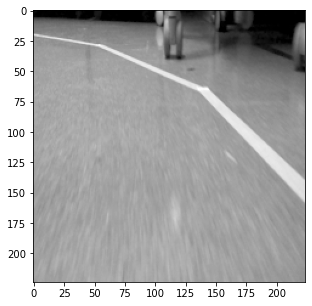

In [28]:
num=0
batch=next(iter(test_d_loader))
img,lab=batch
img=img.reshape(1000,1,224,224)

plt.figure(figsize=(5,5))
plt.imshow(img[num].squeeze(),cmap='gray')
image=img[num].unsqueeze(0)
print(network(image))
print(lab[0])
# liss=lab.tolist()
# print(liss)
# plt.hist(liss, bins=10)
# plt.show()